<a href="https://colab.research.google.com/github/Bast-94/CYBERML-Project/blob/data-set/cyber-ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Cyber Security Project

In [1]:
! pip install --upgrade pip

! pip install -q tensorflow
! pip install -q openpyxl

In [2]:
import pandas as pd
import numpy as np
import os
import sys
from mlsecu.anomaly_detection_use_case import *
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Prepare Data

### Loading dataset

In [3]:
dataset_path = './data/SWaT.A3_dataset_Jul 19_labelled.xlsx'
df = pd.read_excel(dataset_path, header=1)

In [4]:
df.head()

,GMT +0,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,...,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,timestamp,NaN,NaN,value,value,value,value,value,value,value,...,value,value,value,value,value,value,value,value,value,value
1,2019-07-20T04:30:00Z,NaN,NaN,0,729.8658,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
2,2019-07-20T04:30:01Z,NaN,NaN,0,729.434,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
3,2019-07-20T04:30:02.004013Z,NaN,NaN,0,729.12,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
4,2019-07-20T04:30:03.004013Z,NaN,NaN,0,728.6882,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1


### Cleaning data

In order to work easier on our dataset we need to clean it properly.

In [5]:
# date_format = "%Y-%m-%dT%H:%M:%S.%fZ"
full_df = df.drop([0])
full_df = full_df.reset_index(drop=True)
full_df = full_df.rename(columns={'GMT +0':'Date'})
full_df['Attack'] = full_df['Attack'].fillna('benign')
full_df['Label'] = full_df['Label'].fillna(0).astype(int)
# full_df['Date'] = pd.to_datetime(full_df['Date'])
full_df.to_csv('./data/SWaT.A3_dataset_Jul_19_labelled.csv')
full_df.head()

,Date,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,...,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,2019-07-20T04:30:00Z,benign,0,0,729.8658,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
1,2019-07-20T04:30:01Z,benign,0,0,729.434,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
2,2019-07-20T04:30:02.004013Z,benign,0,0,729.12,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
3,2019-07-20T04:30:03.004013Z,benign,0,0,728.6882,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
4,2019-07-20T04:30:04Z,benign,0,0,727.7069,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1


<Axes: >

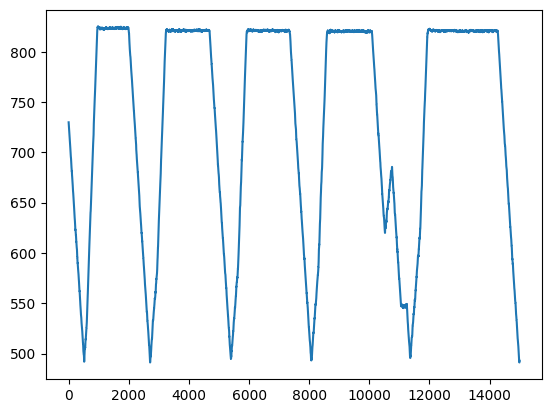

In [6]:
# affiche la colonne LIT 101
full_df['LIT 101'].plot()

In [7]:
# get unique labels
labels = full_df['Attack'].unique()
print(f'Possible labels: {list(labels)}')

Possible labels: ['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off']


In [8]:
print('Columns with only one unique value:')
for col in full_df.columns:
    if (len(full_df[col].unique()) == 1):
        print(col)



Columns with only one unique value:
P102 Status
LS 201
LS 202
LSL 203
LSLL 203
P2_STATE
P201 Status
P202 Status
P204 Status
P206 Status
P207 Status
P208 Status
P302 Status
AIT 401
LS 401
P4_STATE
P402 Status
P403 Status
P404 Status
MV 502
MV 503
MV 504
P5_STATE
P501 Status
P502 Status
LSH 602
LSH 603
LSL 601
LSL 602
LSL 603
P6 STATE
P602 Status
P603 Status


Supprimons les colonnes qui contiennent une seule valeur, car elles ne sont pas utiles pour la classification.

On en compte finalement 33.


In [9]:
# on supprime les colonnes qui ont une seule valeur dans un nouveau dataframe
df_cleaned = full_df.copy()
for col in full_df.columns:
    if len(full_df[col].unique()) == 1:
        df_cleaned = df_cleaned.drop(columns=[col])

In [10]:
print(f'Number of features: {len(df_cleaned.columns)}')
print(f'Number of samples: {len(df_cleaned)}')

Number of features: 47
Number of samples: 14996


In [11]:
df_cleaned.to_csv('./data/SWaT.A3_dataset_Jul_19_labelled_cleaned.csv')
df_cleaned.head()

,Date,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,AIT 201,AIT 202,...,FIT 502,FIT 503,FIT 504,MV 501,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,P601 Status
0,2019-07-20T04:30:00Z,benign,0,0,729.8658,1,3,2,142.527557,9.293002,...,0.310362,0.623628,0.213432,2,167.601257,2.963509,119.921173,0.00032,"{u'IsSystem': False, u'Name': u'Active', u'Val...",1
1,2019-07-20T04:30:01Z,benign,0,0,729.434,1,3,2,142.527557,9.293002,...,0.315102,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,"{u'IsSystem': False, u'Name': u'Active', u'Val...",1
2,2019-07-20T04:30:02.004013Z,benign,0,0,729.12,1,3,2,142.527557,9.293002,...,0.317023,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,"{u'IsSystem': False, u'Name': u'Active', u'Val...",1
3,2019-07-20T04:30:03.004013Z,benign,0,0,728.6882,1,3,2,142.527557,9.289157,...,0.308057,0.623628,0.212792,2,167.601257,2.963509,119.921173,0.00032,"{u'IsSystem': False, u'Name': u'Active', u'Val...",1
4,2019-07-20T04:30:04Z,benign,0,0,727.7069,1,3,2,142.527557,9.289157,...,0.303446,0.623628,0.214009,2,167.601257,2.963509,119.921173,0.00032,"{u'IsSystem': False, u'Name': u'Active', u'Val...",1


## LSTM Model and RMS-deviation

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2023-11-08 16:00:20.219643: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 16:00:20.350613: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 16:00:20.350651: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 16:00:20.351329: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 16:00:20.411799: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 16:00:20.412877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

### Data preparation

Our LSTM must take a specific shape of data. We need to reshape our data in order to fit the model.

Here our dataset has a shape of (14996,49). We know that the LSTM works better with 200-400 time steps per sample. We will use 300 time steps per sample.

15 000 / 60 = 250 samples

Let's have 49 samples with 300 time steps each and the last one with 296 time steps.

n_samples = 250
time_steps = 60
features = 49

In [13]:
is_float = lambda x: isinstance(x, float)
for col in df_cleaned.columns:
  if col == 'Date':
    continue

  if df_cleaned[col].apply(pd.to_numeric, errors='coerce').notna().all():
    df_cleaned[col] = df_cleaned[col].apply(pd.to_numeric, errors='coerce')

In [14]:
# format the data for LSTM like this [samples, time steps, features]
features = df_cleaned.drop(['Date', 'Attack', 'Label', "LSH 601"], axis=1)
labels = df_cleaned['Label']

# Normalisation
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

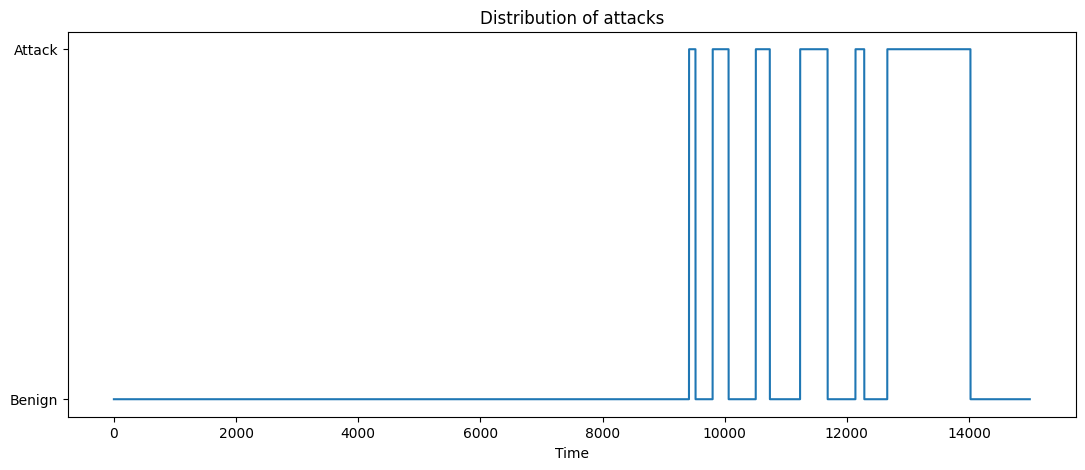

In [15]:
# plot labels
plt.figure(figsize=(13, 5))
plt.plot(labels)
plt.xlabel('Time')
plt.yticks([0, 1], ['Benign', 'Attack'])
plt.title("Distribution of attacks")

plt.savefig('./figures/attacks_distribution.png')

Afin d'implémenter un LSTM il faut générer le dataset issue de nos série temporelles. Le but sera d'extraire plusieurs séquences d'une taille de séquence définie et de lui affecter un label. Si une séquence contient une valeur  `Label` à 1 alors toute la séquence est labellisée comme étant à 1.

### LSTM avec fenetres glissantes seq2one


In [16]:
len_sequence = 180
len_start = len_sequence
len_end = len(labels) - len_sequence

X_hist, X_fut, y = [], [], []
for i in range(len_start, len_end):
    X_hist.append(features_scaled[i:i+len_sequence])
    X_fut.append(features_scaled[i+len_sequence])
    y.append(labels[i+len_sequence])

    
X_hist = np.array(X_hist)
X_fut = np.array(X_fut)
y = np.array(y)

print(f'X_hist shape: {X_hist.shape}')
print(f'X_fut shape: {X_fut.shape}')


X_hist shape: (14636, 180, 43)
X_fut shape: (14636, 43)


In [17]:
np.where(y == 1)[0][0]

9056

In [18]:
# keep 80% of the data for training and 20% for testing
# n_train = int(X_hist.shape[0] * 0.8)

# On entraine le modèle sur les données avant l'attaque
n_train = np.where(y == 1)[0][0] - 1


X_hist_train, X_hist_test = X_hist[:n_train], X_hist[n_train:]
X_fut_train, X_fut_test = X_fut[:n_train], X_fut[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

#shuffle data
shuffle_idx = np.random.permutation(n_train)
X_hist_train, X_fut_train = X_hist_train[shuffle_idx], X_fut_train[shuffle_idx]

In [19]:
print(f'Nombre de séquences d\'entraînement: {X_hist_train.shape[0]}')
print(f'Fenêtre de temps: {X_hist_train.shape[1]}')
print(f'Nombre de séquences de test: {X_hist_test.shape[0]}')

Nombre de séquences d'entraînement: 9055
Fenêtre de temps: 180
Nombre de séquences de test: 5581


In [20]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

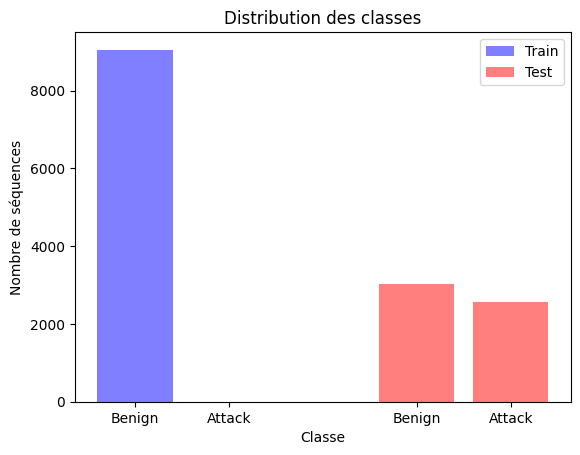

In [21]:
# plt.hist(y_train, bins=2, color='blue', alpha=0.5, label='Train')
# plt.hist(y_test, bins=2, color='red', alpha=0.5, label='Test')

plt.bar([0, 1], [len(y_train[y_train == 0]), len(y_train[y_train == 1])], color='blue', alpha=0.5, label='Train')
plt.bar([3, 4], [len(y_test[y_test == 0]), len(y_test[y_test == 1])], color='red', alpha=0.5, label='Test')
plt.title('Distribution des classes')
plt.xlabel('Classe')
plt.ylabel('Nombre de séquences')
plt.xticks([0, 1, 3, 4], ['Benign', 'Attack', 'Benign', 'Attack'])
plt.legend()

plt.savefig('./figures/Distribution.png', dpi=300)

In [22]:
from tensorflow.keras.layers import LSTM, RepeatVector, Dropout, Dense

def build_model(nb_neurons, len_sequence, nb_features):
    model = tf.keras.Sequential([
        LSTM(nb_neurons, input_shape=(len_sequence, nb_features), return_sequences=True),
        Dropout(0.2),
        LSTM(nb_neurons, return_sequences=False),
        Dropout(0.2),
        Dense(nb_features, activation='sigmoid')
    ])

    return model

nb_features = X_hist_train.shape[2]

model = build_model(nb_neurons=64,
                    len_sequence=len_sequence,
                    nb_features=nb_features)
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 180, 64)           27648     
                                                                 
 dropout (Dropout)           (None, 180, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 43)                2795      
                                                                 
Total params: 63467 (247.92 KB)
Trainable params: 63467 (247.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.mean_squared_error
r2 = tf.keras.metrics.R2Score()
mse = tf.keras.metrics.MeanSquaredError()
metrics = [r2, mse]


model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


history = model.fit(x=X_hist_train,
                    y=X_fut_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=64,
                    verbose="auto")


Epoch 1/10


2023-11-08 16:00:29.393507: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 224274240 exceeds 10% of free system memory.


114/114 [==============================] - ETA: 0s - loss: 0.0389 - r2_score: -21703.9238 - mean_squared_error: 0.0389

2023-11-08 16:00:48.013799: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56068560 exceeds 10% of free system memory.


114/114 [==============================] - 20s 146ms/step - loss: 0.0389 - r2_score: -21703.9238 - mean_squared_error: 0.0389 - val_loss: 0.0096 - val_r2_score: -1468.3750 - val_mean_squared_error: 0.0096
Epoch 2/10
114/114 [==============================] - 16s 144ms/step - loss: 0.0104 - r2_score: -1965.3776 - mean_squared_error: 0.0104 - val_loss: 0.0047 - val_r2_score: -908.7587 - val_mean_squared_error: 0.0047
Epoch 3/10
114/114 [==============================] - 17s 152ms/step - loss: 0.0066 - r2_score: -1096.9359 - mean_squared_error: 0.0066 - val_loss: 0.0038 - val_r2_score: -417.2857 - val_mean_squared_error: 0.0038
Epoch 4/10
114/114 [==============================] - 18s 159ms/step - loss: 0.0051 - r2_score: -687.2983 - mean_squared_error: 0.0051 - val_loss: 0.0026 - val_r2_score: -286.2662 - val_mean_squared_error: 0.0026
Epoch 5/10
114/114 [==============================] - 22s 190ms/step - loss: 0.0041 - r2_score: -500.6085 - mean_squared_error: 0.0041 - val_loss: 0.0022 

In [ ]:
def plot_history(history):
    plt.figure(figsize=(13, 5))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss MSE')
    plt.legend()

plot_history(history)
plt.savefig('./figures/history.png')

In [ ]:
def RMS_deviation(predicted, X_fut_test):
    rms = np.sqrt(np.mean(np.power((predicted - X_fut_test), 2), axis=1))
    return rms

dict_df = {col:i for i, col in enumerate(features.columns)}
predicted = model.predict(X_hist_test)
rms = RMS_deviation(predicted, X_fut_test)


In [ ]:
def rms_feature(rms, feature_name):
    feature = dict_df[feature_name]
    power = np.power((predicted[:, feature] - X_fut_test[:, feature]), 2)
    rms = np.sqrt(power)
    return rms


rms_lit = rms_feature(rms, 'LIT 101')
def plot_history_feature(feature_name):
    plt.plot(predicted[:, dict_df[feature_name]], label='Predicted')
    plt.plot(X_fut_test[:, dict_df[feature_name]], label='True')
    # plt.plot(rms_lit, label='RMS')
    plt.title("RMS for LIT 101")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

plt.figure(figsize=(13, 10))
plt.subplot(2, 2, 1)
plot_history_feature('LIT 101')
plt.subplot(2, 2, 2)
plot_history_feature('AIT 301')
plt.subplot(2, 2, 3)
plot_history_feature('AIT 302')
plt.suptitle('Few examples Predicted vs True')

In [ ]:
attack = df_cleaned["Attack"][n_train+len_start*2:].reset_index(drop=True)
attacks = attack.unique()
attacks

In [ ]:
threshold = 0.17

plt.figure(figsize=(13, 5))
plt.plot(rms, label='RMS')
# plt.scatter(np.where(y_test == 1), y_test[y_test == 1], color='red', label='Attack', s=5)
for i in range(1, len(attacks)):
    bool1 = attack == attacks[i]
    idx = attack[bool1].index
    plt.scatter(idx, np.ones(shape=len(idx)), label=attacks[i], s=5)
    
plt.fill_between(np.arange(len(rms)), rms, 0, where=(rms > threshold), facecolor='orange', alpha=0.3, label='RMS > Threshold')
plt.fill_between(np.arange(len(rms)), rms, 1.1, where=(rms > threshold), facecolor='orange', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('RMS')
plt.title('Detection of anomalies with RMS')
plt.legend()

plt.savefig('./figures/Detection of anomalies with RMS.png')



In [ ]:
# Metrics
tp = np.where((rms >= threshold) & (y_test == 1))[0]
fp = np.where((rms >= threshold) & (y_test == 0))[0]
tn = np.where((rms < threshold) & (y_test == 0))[0]
fn = np.where((rms < threshold) & (y_test == 1))[0]


recall = len(tp) / (len(tp) + len(fn))
precision = len(tp) / (len(tp) + len(fp))
f1 = 2 * (precision * recall) / (precision + recall)


print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 score: {f1}')


In [ ]:
# save model
#model.save('./data/lstm.h5')